# GraphToolbox - NetLoad Example

This notebook was succesfully tested with Python 3.11.9.

## Importing libraries

Importing all libraries should take a minute or two.

In [1]:
# General libraries
import gc
from scipy.stats import norm
import torch
from torch_geometric.nn.conv import *
from torch_geometric.nn.models import *
from torch_geometric import seed_everything

# GraphToolbox
from graphtoolbox.data.dataset import *
from graphtoolbox.models.gnn import *
from graphtoolbox.optim.optimizer import *
from graphtoolbox.training.trainer import Trainer
from graphtoolbox.utils.attention import *
from graphtoolbox.utils.helper_functions import *
from graphtoolbox.utils.visualizations import *

# Autoreload
%load_ext autoreload
%autoreload 2

/home/a89182/miniconda311/lib/python3.11/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /lib64/libm.so.6: version `GLIBC_2.29' not found (required by /fscronos/home/a89182/miniconda311/lib/python3.11/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/home/a89182/miniconda311/lib/python3.11/site-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /lib64/libm.so.6: version `GLIBC_2.29' not found (required by /fscronos/home/a89182/miniconda311/lib/python3.11/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


## CUDA or not CUDA ?

In [2]:
print('CUDA'*(torch.cuda.is_available())+(1-torch.cuda.is_available())*'not CUDA')

CUDA


## Instantiating graph objects

There are two graph objects in the following cell:

- a **DataClass** object, which is always defined by three arguments: `path_train` which is the path to the training dataset, `path_test` which is the path to the testing dataset, and `folder_config` which is the folder of your config file. There are additional keyword arguments if you want to specify a validation set. A DataClass object allows to manipulate the dataframes easily.

- a **GraphDataset** object, which is always defined by two arguments: `data` which is an instance of DataClass, `period` which specifies if it is a train., val. or test. dataset. If the dataset is for validation or test, then you will need to specify scalers: `scalers_feat` to scale the features, and `scalers_target` to scale the target. There are additional keyword arguments that you can find in the documentation. A GraphDataset object allows to manipulate the data as graph objects in the PyG format.

In [3]:
data_kwargs = {
    'node_var': 'Region',
    'features_to_lag': {'NetLoad': (1, 48), 'temperature': (-47, -1)},
    'dummies': ['tod', 'day_type_week'],
    'day_inf_train': '2014-01-01',
    'day_sup_train': '2018-01-01',
    'day_inf_val': '2018-01-01',
    'day_sup_val': '2018-12-31',
    'day_inf_test': '2019-01-01',
    'day_sup_test': '2019-12-31'
}

features_load = ['temperature', 'temperature_lisse_990', 'temperature_lisse_950', 'wind', 'nebulosity', 
                'toy', 'year', 'month', 'day_type_jf', 'day_type_week', 'period_holiday', 'period_hour_changed',
                'period_holiday_zone_a', 'period_holiday_zone_b', 'period_holiday_zone_c', 'period_christmas', 'period_summer']
features_wind = ['wind', 'wind_by_wind_power_weights', 'toy', 'year', 'month']
features_solar = ['nebulosity', 'nebulosity_by_solar_power_weights', 'toy', 'year', 'month']
features = list(np.unique(list(set(features_load) | set(features_wind) | set(features_solar))))

dataset_kwargs = {
    'batch_size': 32,
    'adj_matrix': 'dtw',
    'features_base': features + [f'NetLoad_l{t}' for t in range(1, 48+1)] + [f'temperature_l{t}' for t in range(-47, -1+1)],
    'target_base': 'NetLoad',
}

out_channels = 48
data = DataClass(path_train='./train.csv', 
                 path_test='./test.csv', 
                 data_kwargs=data_kwargs,
                 folder_config='.')

graph_dataset_train = GraphDataset(data=data, period='train', 
                                   graph_folder='../graph_representations',
                                   dataset_kwargs=dataset_kwargs,
                                   out_channels=out_channels)
graph_dataset_val = GraphDataset(data=data, period='val', 
                                 scalers_feat=graph_dataset_train.scalers_feat, 
                                 scalers_target=graph_dataset_train.scalers_target, 
                                 graph_folder='../graph_representations',
                                 dataset_kwargs=dataset_kwargs,
                                 out_channels=out_channels)
graph_dataset_test = GraphDataset(data=data, period='test', 
                                  scalers_feat=graph_dataset_train.scalers_feat, 
                                  scalers_target=graph_dataset_train.scalers_target, 
                                  graph_folder='../graph_representations',
                                  dataset_kwargs=dataset_kwargs,
                                  out_channels=out_channels)

## Training a graph model

To train your graph models, the GraphToolbox has a training module. To use it, you need to instantiate a `Trainer` object which takes four arguments: `model` which is a graph model, and three GraphDataset objects `dataset_train`, `dataset_val` and `dataset_test`. There are other keyword arguments that you can find in the documentation. Then, when your trainer is instantiated, you can use the `train()` method. Note that if there is a pre-trained model with the same parameters, the trainer will automatically load the pre-trained weights (if you want to train another model with the same parameters, you will need to enforce `force_training=True` in the `train()` method).

Training model...


 57%|█████▊    | 345/600 [03:47<02:48,  1.51it/s]

Early stopping at epoch 345


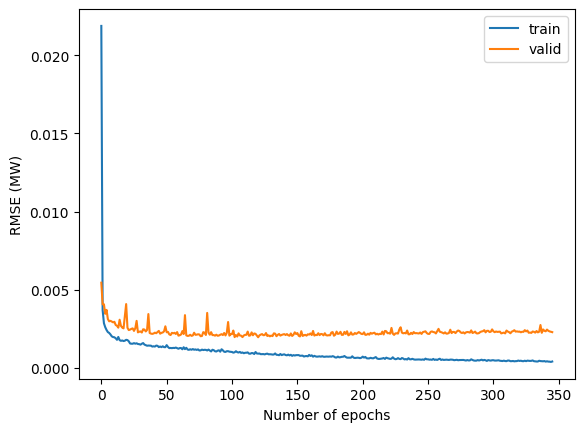

MAPE on test set: 4.2484 %
RMSE on test set: 2674.7227 MW


In [4]:
gc.collect()
torch.cuda.empty_cache()
seed_everything(seed=42)

conv_class = ChebConv
conv_kwargs = {'K': 3}
params = {'num_layers': 1, 'hidden_channels': 249, 'lr': 6e-4, 'batch_size': 16, 'adj_matrix': 'distsplines', 'lam_reg': 0}

graph_dataset_train._set_adj_matrix(adj_matrix=params['adj_matrix'])
graph_dataset_val._set_adj_matrix(adj_matrix=params['adj_matrix'])
graph_dataset_test._set_adj_matrix(adj_matrix=params['adj_matrix'])

model = myGNN(
    in_channels=graph_dataset_train.num_node_features,
    num_layers=params["num_layers"],
    hidden_channels=params["hidden_channels"],
    out_channels=out_channels,
    conv_class=conv_class,
    conv_kwargs=conv_kwargs
)
trainer = Trainer(
    model=model,
    dataset_train=graph_dataset_train,
    dataset_val=graph_dataset_val,
    dataset_test=graph_dataset_test,
    batch_size=params["batch_size"],
    return_attention=False,
    model_kwargs={'lr': params["lr"], 'num_epochs': 600},
    lam_reg=0
)

pred_model_test, target_test, edge_index, attention_weights = trainer.train(
    plot_loss=True,
    force_training=True,
    save=True,
    patience=225
)
trainer.evaluate()

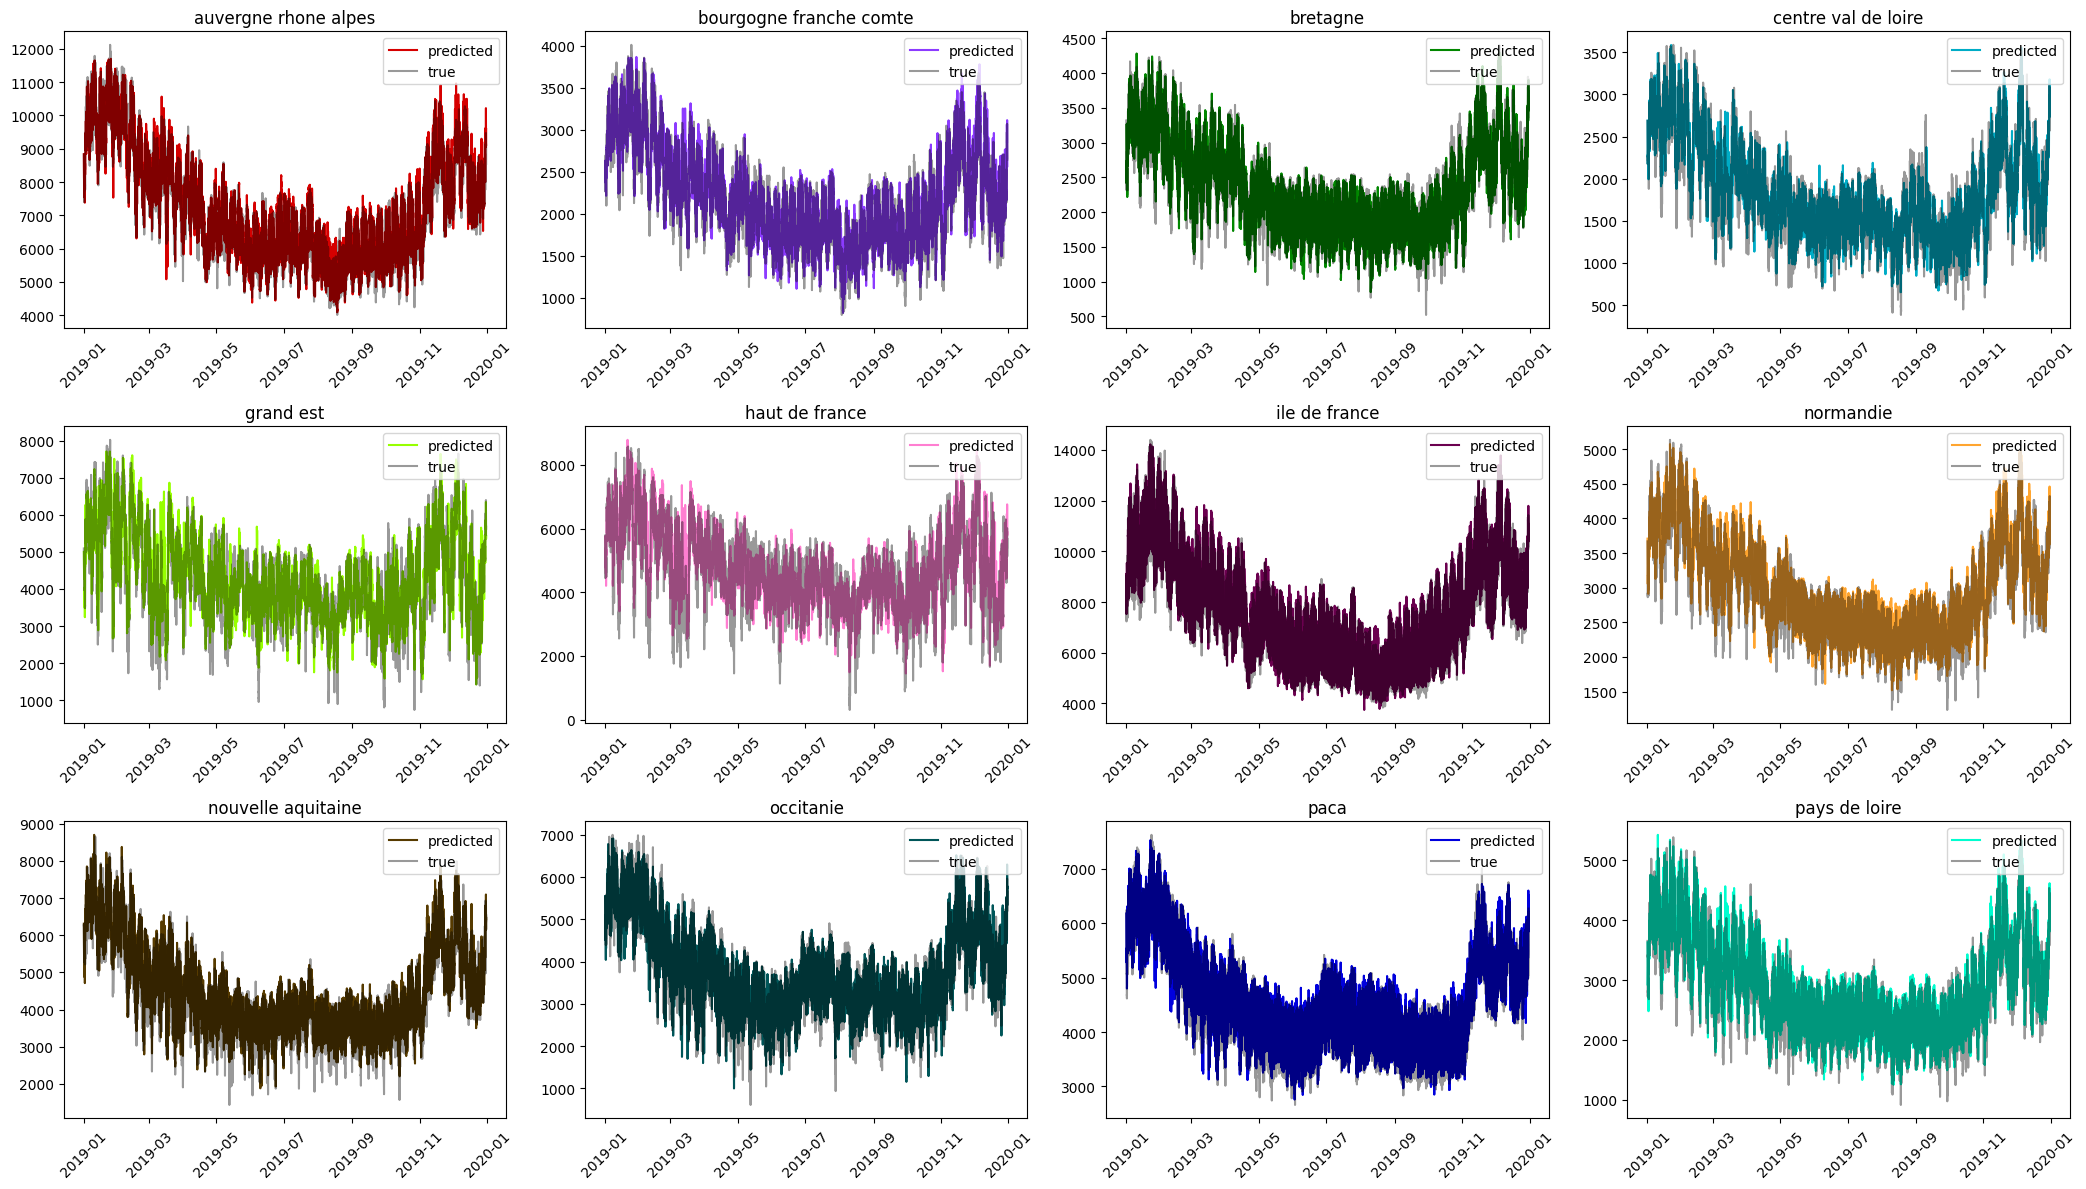

In [5]:
plot_nodes(true=target_test, pred=pred_model_test, graph_dataset=graph_dataset_test)

In [6]:
for i in range(pred_model_test.shape[0]):
    region = graph_dataset_train.nodes[i]
    preds = pred_model_test[i].cpu().detach()
    targets = target_test[i]
    print(f'RMSE {region} = {torch.round(RMSE(preds=preds, targets=targets))} MW')
    print(f'BIAS {region} = {torch.round(BIAS(preds=preds, targets=targets))} MW')
    print(f'MAPE {region} = {100*(MAPE(preds=preds, targets=targets))} %')

print(f'RMSE national = {torch.round(RMSE(preds=pred_model_test.sum(axis=0).cpu().detach(), targets=target_test.sum(axis=0)))} MW')
print(f'BIAS national = {torch.round(BIAS(preds=pred_model_test.sum(axis=0).cpu().detach(), targets=target_test.sum(axis=0)))} MW')
print(f'MAPE national = {100*(MAPE(preds=pred_model_test.sum(axis=0).cpu().detach(), targets=target_test.sum(axis=0)))} %')

RMSE auvergne_rhone_alpes = 339.0 MW
BIAS auvergne_rhone_alpes = -116.0 MW
MAPE auvergne_rhone_alpes = 3.666849136352539 %
RMSE bourgogne_franche_comte = 179.0 MW
BIAS bourgogne_franche_comte = -43.0 MW
MAPE bourgogne_franche_comte = 6.548402309417725 %
RMSE bretagne = 202.0 MW
BIAS bretagne = -20.0 MW
MAPE bretagne = 6.865052700042725 %
RMSE centre_val_de_loire = 224.0 MW
BIAS centre_val_de_loire = -28.0 MW
MAPE centre_val_de_loire = 10.457253456115723 %
RMSE grand_est = 620.0 MW
BIAS grand_est = -113.0 MW
MAPE grand_est = 12.615087509155273 %
RMSE haut_de_france = 765.0 MW
BIAS haut_de_france = -144.0 MW
MAPE haut_de_france = 14.618468284606934 %
RMSE ile_de_france = 344.0 MW
BIAS ile_de_france = -99.0 MW
MAPE ile_de_france = 3.4458253383636475 %
RMSE normandie = 199.0 MW
BIAS normandie = -71.0 MW
MAPE normandie = 5.406588554382324 %
RMSE nouvelle_aquitaine = 349.0 MW
BIAS nouvelle_aquitaine = -105.0 MW
MAPE nouvelle_aquitaine = 6.63544225692749 %
RMSE occitanie = 350.0 MW
BIAS occit

National MAPE = 4.25 %


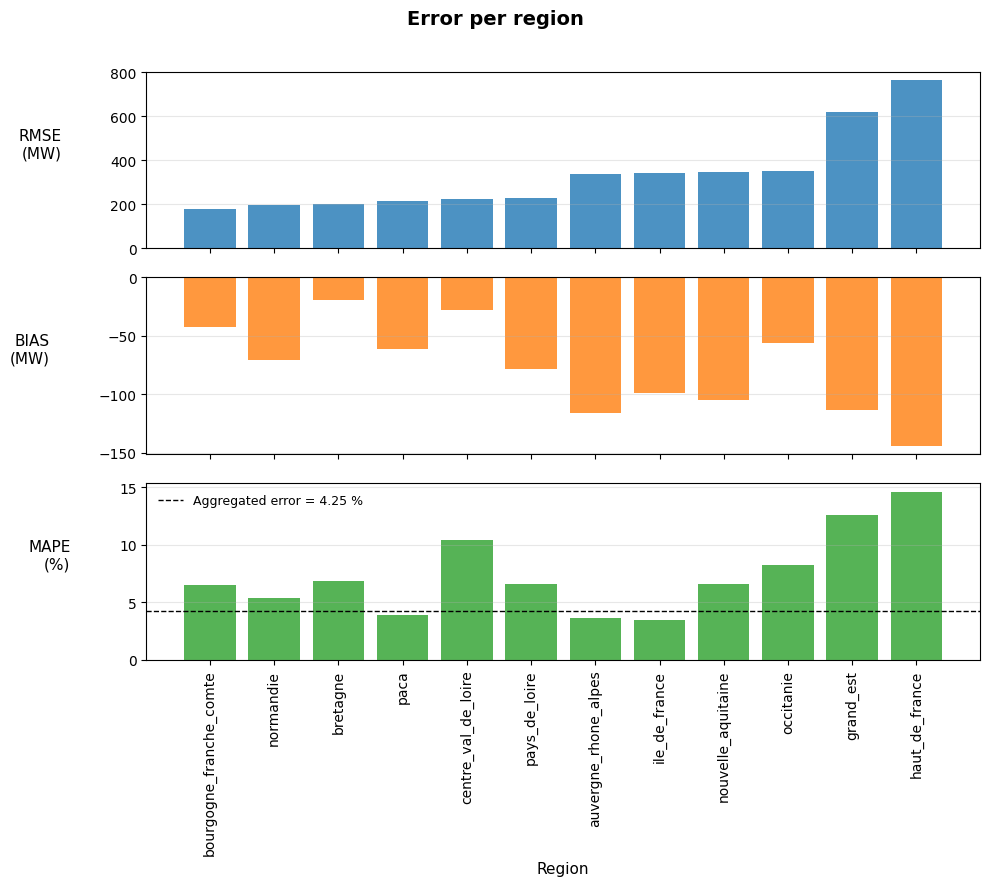

In [26]:
data = []
for i in range(pred_model_test.shape[0]):
    region = graph_dataset_train.nodes[i]
    preds = pred_model_test[i].cpu().detach()
    targets = target_test[i]
    data.append({
        "region": region,
        "RMSE": RMSE(preds=preds, targets=targets).item(),
        "BIAS": BIAS(preds=preds, targets=targets).item(),
        "MAPE": 100 * MAPE(preds=preds, targets=targets).item()
    })

df = pd.DataFrame(data)
df_sorted = df.sort_values("RMSE", ascending=True)

# --- Calcul des valeurs nationales ---
preds_sum = pred_model_test.sum(axis=0).cpu().detach()
targets_sum = target_test.sum(axis=0)

agg_metrics = {
    "MAPE": 100 * MAPE(preds=preds_sum, targets=targets_sum).item()
}

for k, v in agg_metrics.items():
    unit = "MW" if k != "MAPE" else "%"
    print(f"National {k} = {v:.2f} {unit}")

# --- Plot ---
metrics = ["RMSE", "BIAS", "MAPE"]
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]  # bleu, orange, vert
units = {"RMSE": "MW", "BIAS": "MW", "MAPE": "%"}

fig, axes = plt.subplots(3, 1, figsize=(10, 9), sharex=True)
fig.suptitle("Error per region", fontsize=14, weight="bold")

for ax, metric, color in zip(axes, metrics, colors):
    ax.bar(df_sorted["region"], df_sorted[metric], color=color, alpha=0.8)
    if metric == 'MAPE':
        ax.axhline(
            agg_metrics[metric],
            color="black",
            linestyle="--",
            linewidth=1,
            label=f"Aggregated error = {agg_metrics[metric]:.2f} {units[metric]}"
        )
    ax.grid(True, axis="y", alpha=0.3)
    ax.set_ylabel(f"{metric}\n({units[metric]})", rotation=0, labelpad=35, ha="right", fontsize=11)
    if metric == 'MAPE':
        ax.legend(frameon=False, loc="upper left", fontsize=9)

axes[-1].set_xlabel("Region", fontsize=11)
plt.xticks(rotation=90)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


Moyenne     : 6.5965
Écart-type  : 2.6605
Min         : 3.3259
Q25         : 4.7252
Médiane Q50 : 6.0526
Q75         : 7.7187
Max         : 11.9425


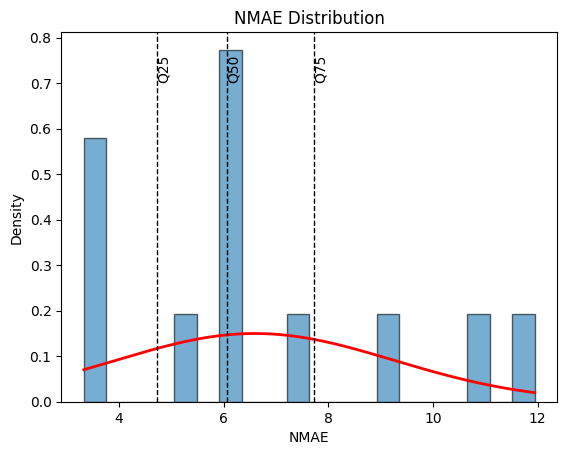

In [7]:
nmae_scores = []
for i in range(len(target_test)):
    score = 100*NMAE(
        preds=pred_model_test[i].cpu().detach(),
        targets=target_test[i]
    ).item()
    nmae_scores.append(score)
nmae_scores = np.array(nmae_scores)

mean = nmae_scores.mean()
std = nmae_scores.std()
q25, q50, q75 = np.percentile(nmae_scores, [25, 50, 75])

print(f"Moyenne     : {mean:.4f}")
print(f"Écart-type  : {std:.4f}")
print(f"Min         : {nmae_scores.min():.4f}")
print(f"Q25         : {q25:.4f}")
print(f"Médiane Q50 : {q50:.4f}")
print(f"Q75         : {q75:.4f}")
print(f"Max         : {nmae_scores.max():.4f}")

plt.hist(nmae_scores, bins=20, density=True, alpha=0.6, edgecolor="black")

x = np.linspace(nmae_scores.min(), nmae_scores.max(), 600)
pdf = norm.pdf(x, loc=mean, scale=std)
plt.plot(x, pdf, "r-", lw=2)

for q, label in zip([q25, q50, q75], ["Q25", "Q50", "Q75"]):
    plt.axvline(q, color="k", linestyle="--", linewidth=1)
    plt.text(q, plt.ylim()[1]*0.9, label, rotation=90, verticalalignment="center")

plt.xlabel("NMAE")
plt.ylabel("Density")
plt.title("NMAE Distribution")
plt.show()


# 1 GNN/load + 1 GNN/wind + 1 GNN/solar

In [8]:
data_kwargs = {
    'node_var': 'Region',
    'features_to_lag': {'Load': (1, 48), 'Wind_power': (1, 48), 'Solar_power': (1, 48), 'temperature': (-47, -1)},
    'dummies': ['tod', 'day_type_week'],
    'day_inf_train': '2014-01-01',
    'day_sup_train': '2018-01-01',
    'day_inf_val': '2018-01-01',
    'day_sup_val': '2018-12-31',
    'day_inf_test': '2019-01-01',
    'day_sup_test': '2019-12-31'
}

features_load = ['temperature', 'temperature_lisse_990', 'temperature_lisse_950', 'wind', 'nebulosity', 
                'toy', 'year', 'month', 'day_type_jf', 'day_type_week', 'period_holiday', 'period_hour_changed',
                'period_holiday_zone_a', 'period_holiday_zone_b', 'period_holiday_zone_c', 'period_christmas', 'period_summer']
features_wind = ['wind', 'wind_by_wind_power_weights', 'toy', 'year', 'month']
features_solar = ['nebulosity', 'nebulosity_by_solar_power_weights', 'toy', 'year', 'month']

dataset_kwargs_load = {
    'batch_size': 32,
    'adj_matrix': 'dtw',
    'features_base': features_load + [f'Load_l{t}' for t in range(1, 48+1)] + [f'temperature_l{t}' for t in range(-47, -1+1)],
    'target_base': 'Load',
}

dataset_kwargs_wind = {
    'batch_size': 32,
    'adj_matrix': 'dtw',
    'features_base': features_wind + [f'Wind_power_l{t}' for t in range(1, 48+1)] + [f'temperature_l{t}' for t in range(-47, -1+1)],
    'target_base': 'Wind_power',
}

dataset_kwargs_solar = {
    'batch_size': 32,
    'adj_matrix': 'dtw',
    'features_base': features_solar + [f'Solar_power_l{t}' for t in range(1, 48+1)] + [f'temperature_l{t}' for t in range(-47, -1+1)],
    'target_base': 'Solar_power',
}

out_channels = 48
data = DataClass(path_train='./train.csv', 
                path_test='./test.csv', 
                data_kwargs=data_kwargs,
                folder_config='.')

### LOAD
graph_dataset_train_load = GraphDataset(data=data, period='train', 
                                        graph_folder='../graph_representations',
                                        dataset_kwargs=dataset_kwargs_load,
                                        out_channels=out_channels)
graph_dataset_val_load = GraphDataset(data=data, period='val', 
                                        scalers_feat=graph_dataset_train_load.scalers_feat, 
                                        scalers_target=graph_dataset_train_load.scalers_target, 
                                        graph_folder='../graph_representations',
                                        dataset_kwargs=dataset_kwargs_load,
                                        out_channels=out_channels)
graph_dataset_test_load = GraphDataset(data=data, period='test', 
                                        scalers_feat=graph_dataset_train_load.scalers_feat, 
                                        scalers_target=graph_dataset_train_load.scalers_target, 
                                        graph_folder='../graph_representations',
                                        dataset_kwargs=dataset_kwargs_load,
                                        out_channels=out_channels)
### WIND
graph_dataset_train_wind = GraphDataset(data=data, period='train', 
                                        graph_folder='../graph_representations',
                                        dataset_kwargs=dataset_kwargs_wind,
                                        out_channels=out_channels)
graph_dataset_val_wind = GraphDataset(data=data, period='val', 
                                        scalers_feat=graph_dataset_train_wind.scalers_feat, 
                                        scalers_target=graph_dataset_train_wind.scalers_target, 
                                        graph_folder='../graph_representations',
                                        dataset_kwargs=dataset_kwargs_wind,
                                        out_channels=out_channels)
graph_dataset_test_wind = GraphDataset(data=data, period='test', 
                                        scalers_feat=graph_dataset_train_wind.scalers_feat, 
                                        scalers_target=graph_dataset_train_wind.scalers_target, 
                                        graph_folder='../graph_representations',
                                        dataset_kwargs=dataset_kwargs_wind,
                                        out_channels=out_channels)
### SOLAR
graph_dataset_train_solar = GraphDataset(data=data, period='train', 
                                        graph_folder='../graph_representations',
                                        dataset_kwargs=dataset_kwargs_solar,
                                        out_channels=out_channels)
graph_dataset_val_solar = GraphDataset(data=data, period='val', 
                                        scalers_feat=graph_dataset_train_solar.scalers_feat, 
                                        scalers_target=graph_dataset_train_solar.scalers_target, 
                                        graph_folder='../graph_representations',
                                        dataset_kwargs=dataset_kwargs_solar,
                                        out_channels=out_channels)
graph_dataset_test_solar = GraphDataset(data=data, period='test', 
                                        scalers_feat=graph_dataset_train_solar.scalers_feat, 
                                        scalers_target=graph_dataset_train_solar.scalers_target, 
                                        graph_folder='../graph_representations',
                                        dataset_kwargs=dataset_kwargs_solar,
                                        out_channels=out_channels)

In [9]:
print(graph_dataset_test_load[0])
print(graph_dataset_test_wind[0])
print(graph_dataset_test_solar[0])

Data(x=[12, 164], edge_index=[2, 142], y=[12, 48], y_scaled=[12, 48], edge_weight=[142], mask_X=[12, 164], mask_y=[12, 48])
Data(x=[12, 153], edge_index=[2, 142], y=[12, 48], y_scaled=[12, 48], edge_weight=[142], mask_X=[12, 153], mask_y=[12, 48])
Data(x=[12, 153], edge_index=[2, 142], y=[12, 48], y_scaled=[12, 48], edge_weight=[142], mask_X=[12, 153], mask_y=[12, 48])


In [10]:
### LOAD
conv_class_load = ChebConv
conv_kwargs_load = {'K': 3}
params_load = {'num_layers': 1, 'hidden_channels': 249, 'lr': 6e-4, 'batch_size': 16, 'adj_matrix': 'distsplines', 'lam_reg': 0}
graph_dataset_train_load._set_adj_matrix(adj_matrix=params_load['adj_matrix'])
graph_dataset_val_load._set_adj_matrix(adj_matrix=params_load['adj_matrix'])
graph_dataset_test_load._set_adj_matrix(adj_matrix=params_load['adj_matrix'])
### WIND
conv_class_wind = ChebConv
conv_kwargs_wind = {'K': 3}
params_wind = {'num_layers': 1, 'hidden_channels': 249, 'lr': 6e-4, 'batch_size': 16, 'adj_matrix': 'distsplines', 'lam_reg': 0}
graph_dataset_train_wind._set_adj_matrix(adj_matrix=params_wind['adj_matrix'])
graph_dataset_val_wind._set_adj_matrix(adj_matrix=params_wind['adj_matrix'])
graph_dataset_test_wind._set_adj_matrix(adj_matrix=params_wind['adj_matrix'])
### SOLAR
conv_class_solar = ChebConv
conv_kwargs_solar = {'K': 3}
params_solar = {'num_layers': 1, 'hidden_channels': 249, 'lr': 6e-4, 'batch_size': 16, 'adj_matrix': 'distsplines', 'lam_reg': 0}
graph_dataset_train_solar._set_adj_matrix(adj_matrix=params_solar['adj_matrix'])
graph_dataset_val_solar._set_adj_matrix(adj_matrix=params_solar['adj_matrix'])
graph_dataset_test_solar._set_adj_matrix(adj_matrix=params_solar['adj_matrix'])


Training model...


100%|██████████| 200/200 [02:10<00:00,  1.53it/s]


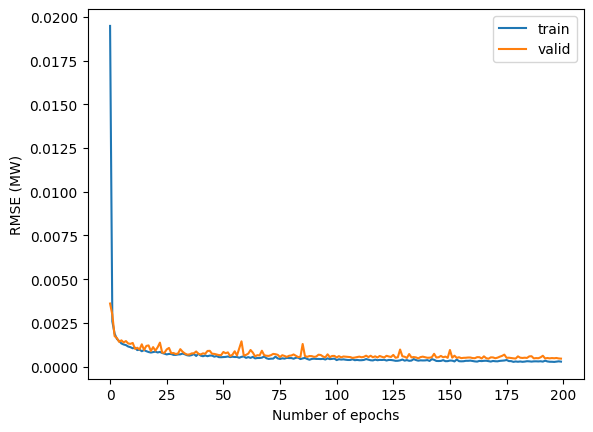

MAPE on test set: 1.1975 %
RMSE on test set: 885.1353 MW


In [11]:
model_load = myGNN(
    in_channels=graph_dataset_train_load.num_node_features,
    num_layers=params_load["num_layers"],
    hidden_channels=params_load["hidden_channels"],
    out_channels=out_channels,
    conv_class=conv_class_load,
    conv_kwargs=conv_kwargs_load
)
trainer = Trainer(
    model=model_load,
    dataset_train=graph_dataset_train_load,
    dataset_val=graph_dataset_val_load,
    dataset_test=graph_dataset_test_load,
    batch_size=params_load["batch_size"],
    return_attention=False,
    model_kwargs={'lr': params_load["lr"], 'num_epochs': 200},
    lam_reg=0
)

pred_model_test_load, target_test_load, edge_index, attention_weights_load = trainer.train(
    plot_loss=True,
    force_training=True,
    save=True,
    patience=75
)
trainer.evaluate()

Training model...


 54%|█████▍    | 108/200 [01:12<01:01,  1.50it/s]

Early stopping at epoch 108


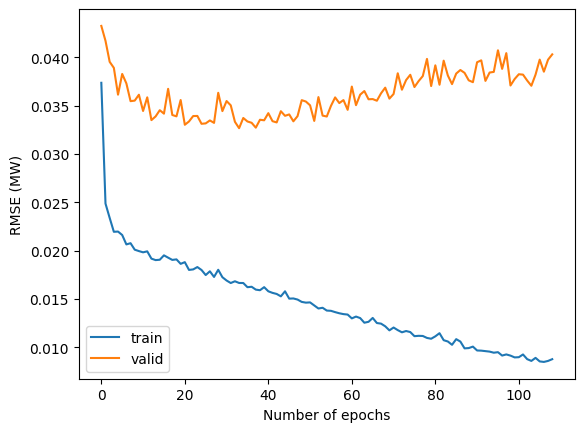

MAPE on test set: 45.3597 %
RMSE on test set: 2018.0366 MW


In [12]:
model_wind = myGNN(
    in_channels=graph_dataset_train_wind.num_node_features,
    num_layers=params_wind["num_layers"],
    hidden_channels=params_wind["hidden_channels"],
    out_channels=out_channels,
    conv_class=conv_class_wind,
    conv_kwargs=conv_kwargs_wind
)
trainer = Trainer(
    model=model_wind,
    dataset_train=graph_dataset_train_wind,
    dataset_val=graph_dataset_val_wind,
    dataset_test=graph_dataset_test_wind,
    batch_size=params_wind["batch_size"],
    return_attention=False,
    model_kwargs={'lr': params_wind["lr"], 'num_epochs': 200},
    lam_reg=0
)

pred_model_test_wind, target_test_wind, edge_index, attention_weights_wind = trainer.train(
    plot_loss=True,
    force_training=True,
    save=True,
    patience=75
)
trainer.evaluate()

Training model...


 64%|██████▍   | 129/200 [01:24<00:46,  1.53it/s]

Early stopping at epoch 129


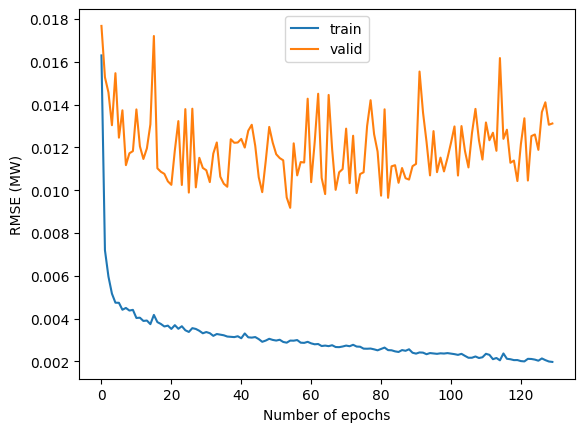

MAPE on test set: 810688600.0000 %
RMSE on test set: 669.6301 MW


In [13]:
model_solar = myGNN(
    in_channels=graph_dataset_train_solar.num_node_features,
    num_layers=params_solar["num_layers"],
    hidden_channels=params_solar["hidden_channels"],
    out_channels=out_channels,
    conv_class=conv_class_solar,
    conv_kwargs=conv_kwargs_solar
)
trainer = Trainer(
    model=model_solar,
    dataset_train=graph_dataset_train_solar,
    dataset_val=graph_dataset_val_solar,
    dataset_test=graph_dataset_test_solar,
    batch_size=params_solar["batch_size"],
    return_attention=False,
    model_kwargs={'lr': params_solar["lr"], 'num_epochs': 200},
    lam_reg=0
)

pred_model_test_solar, target_test_solar, edge_index, attention_weights_solar = trainer.train(
    plot_loss=True,
    force_training=True,
    save=True,
    patience=75
)
trainer.evaluate()

In [16]:
pred_model_test_all = pred_model_test_load - (pred_model_test_wind + pred_model_test_solar)
target_test_all = target_test

for i in range(pred_model_test.shape[0]):
    region = graph_dataset_train.nodes[i]
    preds = pred_model_test_all[i].cpu().detach()
    targets = target_test_all[i]
    print(f'RMSE {region} = {torch.round(RMSE(preds=preds, targets=targets))} MW')
    print(f'BIAS {region} = {torch.round(BIAS(preds=preds, targets=targets))} MW')
    print(f'MAPE {region} = {100*(MAPE(preds=preds, targets=targets))} %')

print(f'RMSE national = {torch.round(RMSE(preds=pred_model_test_all.sum(axis=0).cpu().detach(), targets=target_test_all.sum(axis=0)))} MW')
print(f'BIAS national = {torch.round(BIAS(preds=pred_model_test_all.sum(axis=0).cpu().detach(), targets=target_test_all.sum(axis=0)))} MW')
print(f'MAPE national = {100*(MAPE(preds=pred_model_test_all.sum(axis=0).cpu().detach(), targets=target_test_all.sum(axis=0)))} %')

RMSE auvergne_rhone_alpes = 221.0 MW
BIAS auvergne_rhone_alpes = -71.0 MW
MAPE auvergne_rhone_alpes = 2.330777168273926 %
RMSE bourgogne_franche_comte = 155.0 MW
BIAS bourgogne_franche_comte = -35.0 MW
MAPE bourgogne_franche_comte = 5.654074192047119 %
RMSE bretagne = 177.0 MW
BIAS bretagne = 4.0 MW
MAPE bretagne = 5.939454078674316 %
RMSE centre_val_de_loire = 217.0 MW
BIAS centre_val_de_loire = -62.0 MW
MAPE centre_val_de_loire = 10.180853843688965 %
RMSE grand_est = 583.0 MW
BIAS grand_est = -136.0 MW
MAPE grand_est = 11.776484489440918 %
RMSE haut_de_france = 756.0 MW
BIAS haut_de_france = -263.0 MW
MAPE haut_de_france = 14.409011840820312 %
RMSE ile_de_france = 204.0 MW
BIAS ile_de_france = -41.0 MW
MAPE ile_de_france = 2.044802188873291 %
RMSE normandie = 173.0 MW
BIAS normandie = -57.0 MW
MAPE normandie = 4.560165882110596 %
RMSE nouvelle_aquitaine = 305.0 MW
BIAS nouvelle_aquitaine = -140.0 MW
MAPE nouvelle_aquitaine = 5.822267532348633 %
RMSE occitanie = 366.0 MW
BIAS occitani

National MAPE = 3.75 %


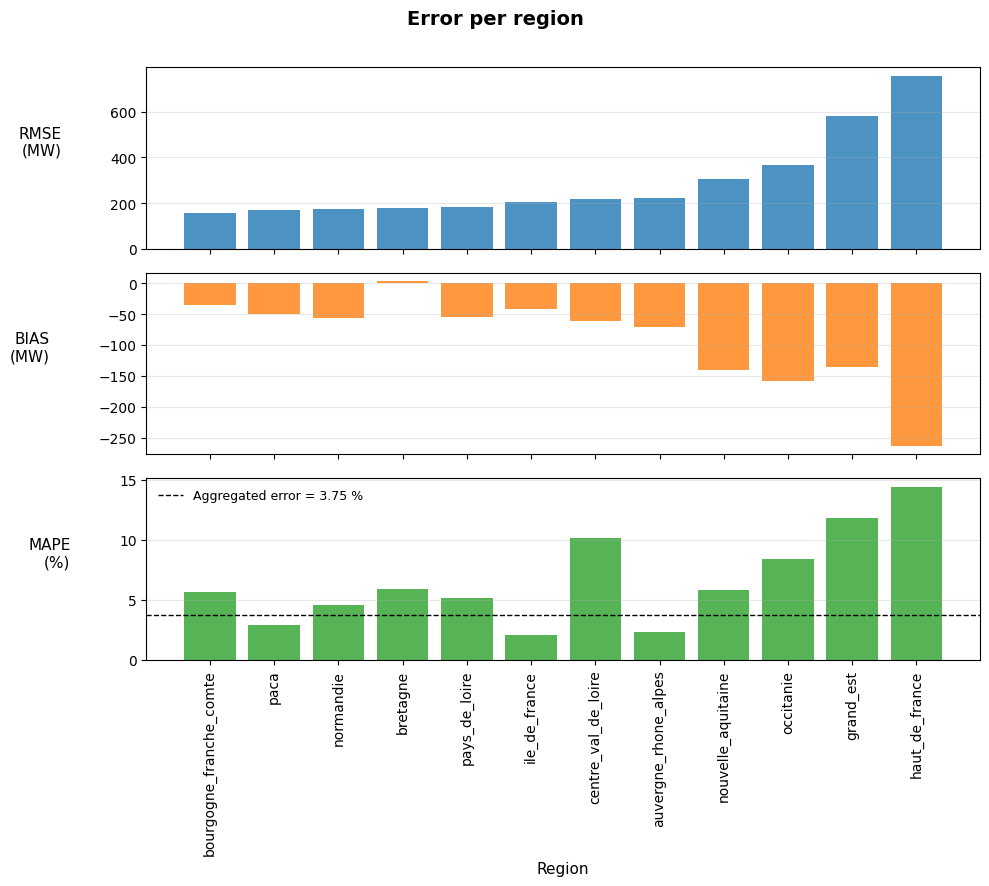

In [25]:
data = []
for i in range(pred_model_test_all.shape[0]):
    region = graph_dataset_train.nodes[i]
    preds = pred_model_test_all[i].cpu().detach()
    targets = target_test_all[i]
    data.append({
        "region": region,
        "RMSE": RMSE(preds=preds, targets=targets).item(),
        "BIAS": BIAS(preds=preds, targets=targets).item(),
        "MAPE": 100 * MAPE(preds=preds, targets=targets).item()
    })

df = pd.DataFrame(data)
df_sorted = df.sort_values("RMSE", ascending=True)

# --- Calcul des valeurs nationales ---
preds_sum = pred_model_test_all.sum(axis=0).cpu().detach()
targets_sum = target_test_all.sum(axis=0)

agg_metrics = {
    "MAPE": 100 * MAPE(preds=preds_sum, targets=targets_sum).item()
}

for k, v in agg_metrics.items():
    unit = "MW" if k != "MAPE" else "%"
    print(f"National {k} = {v:.2f} {unit}")

# --- Plot ---
metrics = ["RMSE", "BIAS", "MAPE"]
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]  # bleu, orange, vert
units = {"RMSE": "MW", "BIAS": "MW", "MAPE": "%"}

fig, axes = plt.subplots(3, 1, figsize=(10, 9), sharex=True)
fig.suptitle("Error per region", fontsize=14, weight="bold")

for ax, metric, color in zip(axes, metrics, colors):
    ax.bar(df_sorted["region"], df_sorted[metric], color=color, alpha=0.8)
    if metric == 'MAPE':
        ax.axhline(
            agg_metrics[metric],
            color="black",
            linestyle="--",
            linewidth=1,
            label=f"Aggregated error = {agg_metrics[metric]:.2f} {units[metric]}"
        )
    ax.grid(True, axis="y", alpha=0.3)
    ax.set_ylabel(f"{metric}\n({units[metric]})", rotation=0, labelpad=35, ha="right", fontsize=11)
    if metric == 'MAPE':
        ax.legend(frameon=False, loc="upper left", fontsize=9)

axes[-1].set_xlabel("Region", fontsize=11)
plt.xticks(rotation=90)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


Moyenne     : 5.7870
Écart-type  : 2.8957
Min         : 1.9717
Q25         : 3.9103
Médiane Q50 : 5.1749
Q75         : 7.7492
Max         : 11.4682


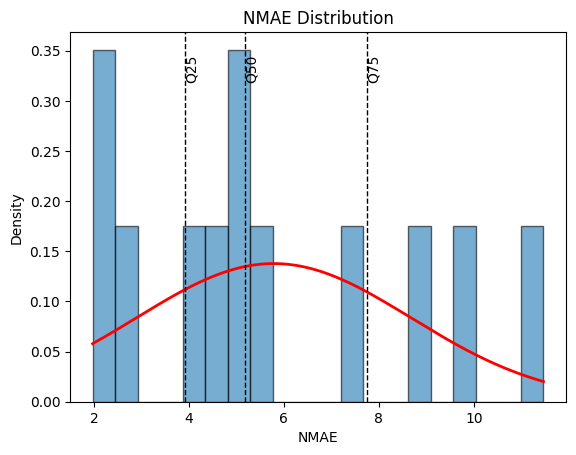

In [17]:
nmae_scores = []
for i in range(len(target_test_all)):
    score = 100*NMAE(
        preds=pred_model_test_all[i].cpu().detach(),
        targets=target_test_all[i]
    ).item()
    nmae_scores.append(score)
nmae_scores = np.array(nmae_scores)

mean = nmae_scores.mean()
std = nmae_scores.std()
q25, q50, q75 = np.percentile(nmae_scores, [25, 50, 75])

print(f"Moyenne     : {mean:.4f}")
print(f"Écart-type  : {std:.4f}")
print(f"Min         : {nmae_scores.min():.4f}")
print(f"Q25         : {q25:.4f}")
print(f"Médiane Q50 : {q50:.4f}")
print(f"Q75         : {q75:.4f}")
print(f"Max         : {nmae_scores.max():.4f}")

plt.hist(nmae_scores, bins=20, density=True, alpha=0.6, edgecolor="black")

x = np.linspace(nmae_scores.min(), nmae_scores.max(), 600)
pdf = norm.pdf(x, loc=mean, scale=std)
plt.plot(x, pdf, "r-", lw=2)

for q, label in zip([q25, q50, q75], ["Q25", "Q50", "Q75"]):
    plt.axvline(q, color="k", linestyle="--", linewidth=1)
    plt.text(q, plt.ylim()[1]*0.9, label, rotation=90, verticalalignment="center")

plt.xlabel("NMAE")
plt.ylabel("Density")
plt.title("NMAE Distribution")
plt.show()
